# Homework #2 (Due 09/25/2019, 11:59pm)
## Sampling and Monte Carlo Integration

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2019**

**Name: Dimitris Vamvourellis**

**Students collaborators:**

### Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. Portions of your submission that contains syntactic or run-time errors will not be graded.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [4]:
### Import basic libraries
import numpy as np
import scipy as sp
from functools import partial
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

## Problem Description

Let $X$ be a random variable with distribution described by the following pdf:

$$
f_X(x) = \begin{cases}
\frac{1}{12}(x-1), &1\leq x\leq 3\\
-\frac{1}{12}(x-5), &3< x\leq 5\\
\frac{1}{6}(x-5), &5< x\leq 7\\
-\frac{1}{6}(x-9), &7< x\leq 9\\
0, &otherwise
\end{cases}
$$

Let $h$ be the following function of the random variable $X$:

$$
h(x) = 7 * \mathrm{exp}\left\{\frac{(x-4)^2}{-2}\right\} + 3 * \mathrm{exp}\left\{\frac{(x-8)^2}{-2 * 0.7^2}\right\}
$$

Our goal is to compute the expected value of $h(X)$:
$$
I = \mathbb{E}_{X\sim f_X}\left[h(X)\right] = \int_{\Omega} h(x) f_X(x)dx,
$$
where $\Omega$ is the domain of $f_X$.

## Part I. Implement Some Monte Carlo Estimates

Approximate $\mathbb{E}_{X\sim f_X}[h(X)]$ using the Monte Carlo integration methods and your choice of a reasonable fixed $S$ (for rejection sampling, this means run the algorithm $S$ times):


1. ***Inverse CDF Sampling*** and naive Monte Carlo estimation.<br><br>

2. ***Rejection Sampling*** and naive Monte Carlo estimation, using each of the following

  - a uniform proposal distribution
  - a normal proposal distribution 

  and your choice of reasonable parameters for the proposal distributions.<br><br>
  
3. ***Importance Sampling*** using each of the following

  - a uniform importance distribution 
  - a normal importance distribution

  and your choice of reasonable parameters for the importance distributions.<br><br>
  
2. ***Stratified Sampling*** using 4 strata, whose end points are given by
$$
[1, 3, 5, 6, 9].
$$
Use inverse cdf sampling on each stratum.

**ANSWER**

**1. Inverse CDF Sampling and Naive Monte Carlo Estimation**

Using Monte Carlo methods the expectation of $h(X)$ can be estimated as follows:

$$I = \mathbb{E}_{X\sim f_X}\left[h(X)\right] = \int_{\Omega} h(x) f_X(x)dx  \approx \frac{1}{S}\sum_{s=1}^S h(X_s),\; X_s\sim f(X).$$

Since $f_X(x)$ defines a pdf in [1,9], it has a CDF in the same domain. To sample from $f_X(x)$, we can use the inverse CDF sampling method, provided that the the CDF can be inverted. The CDF of $f_X(x)$ is given by 

$$F_X(x) = P_f(X \leq \alpha) = \int_{-\infty}^x f(\alpha) da$$

However, $F_X(x)$ takes a different value depending on the the value of $x$.

If $1\leq x\leq 3$, then
$$F_X(x) = \int_{1}^x f(\alpha) da = \frac{1}{24}(x-1)^2$$

If $3 < x\leq 5$, then
$$F_X(x) = \int_{1}^3 f(\alpha) da + \int_{3}^x f(\alpha) da = \frac{2}{12} - \frac{1}{12}(\frac{x^2}{2}-5x+\frac{21}{2}) = \frac{1}{6} + \frac{1}{24}(-x^2+10x-21)$$

If $5 < x\leq 7$, then
$$F_X(x) = \int_{1}^3 f(\alpha) da + \int_{3}^5 f(\alpha) da + \int_{5}^x f(\alpha) da= \frac{1}{6} + \frac{1}{6} + \frac{1}{12}(x-5)^2 = \frac{1}{3} + \frac{1}{12}(x-5)^2 
$$

If $7 < x\leq 9$, then
$$F_X(x) = \int_{1}^3 f(\alpha) da + \int_{3}^5 f(\alpha) da + \int_{5}^7 f(\alpha) da + \int_{7}^x f(\alpha) da= \frac{2}{3} + \frac{1}{12}(-x^2+18x-77) $$

To use the inverse CDF sampling process, we need to calculate the inverse of the CDF for all of the above cases. Performing the calculations, we obtain

$$
F_X^{-1}(x) = \begin{cases}
1+\sqrt{24x}, &0\leq x\leq \frac{1}{6}\\
5-\sqrt{8(1-3x)}, &\frac{1}{6}< x\leq \frac{1}{3}\\
5+\sqrt{4(3x-1)}, &\frac{1}{3}< x\leq \frac{2}{3}\\
9-\sqrt{12}\sqrt{1-x}, &\frac{2}{3}< x\leq 1\\
0, &otherwise
\end{cases}
$$

Please note, that when calculating the inverse for each piece of the piece-wise function function $F$, there were two possible solutions, however we kept the one for which the range of the inverse matched with the domain of $F$ (i.e. + for the first and third piece, - for the second and fourth piece).

Now we can draw samples from $f_X(x)$ using the inverse cdf sampling process to calculate the expected value of $h(x)$ using Monte Carlo as shown below.


In [5]:
#implementation of inverse CDF sampling
#arguments:
#cdf_inv (function): the inverse cdf of the function from which we want to draw samples
#samples (int): number of samples to draw from f(x)
def inverse_cdf_sampling(cdf_inv, S):
    #draw uniform samples in [0,1]
    u_samples = np.random.uniform(0, 1, size=S)
    f_samples = np.zeros(S)
    #for each uniform sample u, calculate f^-1(u) and append it to the list of samples from f
    for i in range(S):
        f_samples[i] = cdf_inv(u_samples[i])
    return f_samples

#implementation of monte carlo estimation algorithm
#arguments:
#sampler (function): the algorithm that draws samples from the function f (e.g. inverse_cdf_sampling)
#g (function): the function that we want to approximate
#samples (int): the number of samples that we want to take to calculate 1 monte carlo estimate
#trials (int): the number of trials that we want to repeat the experiment for, used to calcualte variance of estimate
def monte_carlo(sampler, g, S, trials):
    estimates = []
    for i in range(trials):
        #draw S samples from f using sampler 
        f_samples = sampler(S)
        #compute the value of g for each of the samples
        g_samples = g(f_samples)
        #compute the mean and append it to the list of estiamates from each trial
        estimates.append(g_samples.mean())
    return estimates

#definition of function f
def f(x):
    if (x >= 1 and x <= 3):
        return (x - 1.0)/12.0
    elif (x > 3 and x <= 5):
        return (-x+5.0)/12.0
    elif (x > 5 and x <= 7):
        return (x-5.0)/6.0
    elif (x > 7 and x <= 9):
        return (-x+9.0)/6.0
    else:
        return 0.0

#definition of h
h = lambda x: 7 * np.exp(-0.5*(x-4)**2) + 3*np.exp(((x-8)**2)/(-2*0.7**2))
#definition of inverse cdf of f
def inv_cdf_f(x):
    if (x >= 0 and x <= (1.0/6.0)):
        return 1+np.sqrt(24*x)
    elif (x > (1.0/6.0) and x <= (1.0/3.0)):
        return 5-np.sqrt(8*(1-3*x))
    elif(x > (1.0/3.0) and x <= (2.0/3.0)):
        return 5 + np.sqrt(4*(3*x-1))
    elif (x > (2.0/3.0) and x <= 1):
        return 9 - np.sqrt(12*(1-x))
    else:
        return 0
    
#for first exercise, sampler is the inverse cdf method
#the function that we pass is the inverse cdf of f defined above
inv_cdf_sampler = partial(inverse_cdf_sampling, inv_cdf_f)
#total number of samples for one monte carlo estimate
S = 100
#total number of trials tha we repeat the experiment
trials = 500

inv_cdf_estimates = monte_carlo(inv_cdf_sampler, h, S, trials)

print('Mean of {} trials for naive monte carlo with {} samples using inverse CDF: {}'.format(trials, S, np.mean(inv_cdf_estimates)))
print('Variance of {} trials for naive monte carlo with {} samples using inverse CDF: {}'.format(trials, S, np.std(inv_cdf_estimates)**2))

Mean of 500 trials for naive monte carlo with 100 samples using inverse CDF: 2.4318344697124523
Variance of 500 trials for naive monte carlo with 100 samples using inverse CDF: 0.03334525983094246


**2. Rejection Sampling and Naive Monte Carlo Estimation**

To implement rejection sampling, we choose a proposal disribution $g$ such that the support of $g$ covers the support of $f$ and such that there is a constant $M > 0$ with $\frac{f_X(y)}{g(y)} \leq M$ for all $y$. 

To simulate $X$ from the original function $f$, we repeat until $N$ samples are accepted:
1. sample $Y_k \sim g(Y)$
2. sample a random height, $U_k \sim U(0, 1)$
3. if $U_k < \frac{f_X(Y_k)}{Mg(Y_k)}$ then accept $Y_k$ as a sample, else reject.

To aid our understanding about the choice of g, let's visualize f along with some normal pdfs.

Text(0.5, 1.0, 'target f(x) vs normal pdfs')

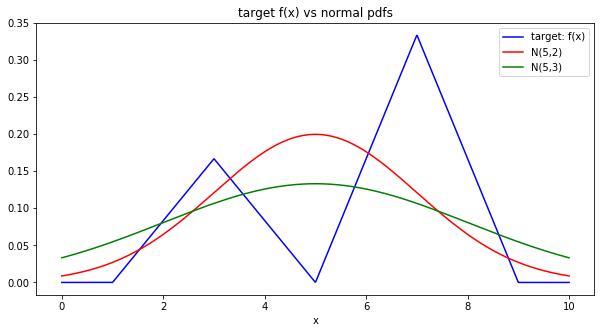

In [6]:
M = 3
norm_5_2 = sp.stats.norm(loc=5, scale=2).pdf
norm_5_3 = sp.stats.norm(loc=5, scale=3).pdf
plt.figure(figsize=(10,5))
x_linspace = np.linspace(0, 10, 1000)
plt.plot(x_linspace, list(map(f, x_linspace)), 'b-', label = 'target: f(x)')
plt.plot(x_linspace, norm_5_2(x_linspace), 'r-', label = 'N(5,2)')
plt.plot(x_linspace, norm_5_3(x_linspace), 'g-', label = 'N(5,3)')
plt.xlabel('x')
plt.legend(loc='best')
plt.title("target f(x) vs normal pdfs")

Experimenting a bit with the Normal pdfs and the value of $M$, we can see in the plot below, that the pdf of $N(5,2)$ with M = 3 is a good candidate to cover the target distribution $f(x)$, so we can proceed with setting this as a proposal.

Text(0.5, 1.0, 'target f(x) vs proposal distribution')

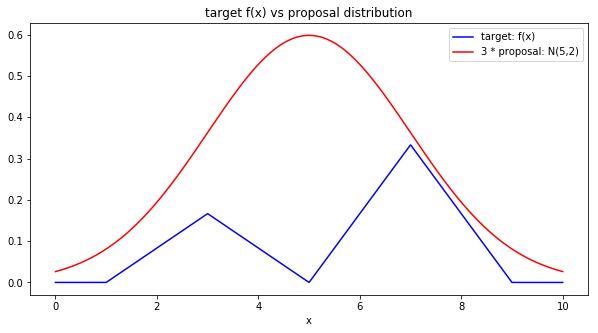

In [7]:
M = 3
plt.figure(figsize=(10,5))
x_linspace = np.linspace(0, 10, 1000)
plt.plot(x_linspace, list(map(f, x_linspace)), 'b-', label = 'target: f(x)')
plt.plot(x_linspace, M*norm_5_2(x_linspace), 'r-', label = '{} * proposal: N(5,2)'.format(M))
plt.xlabel('x')
plt.legend(loc='best')
plt.title("target f(x) vs proposal distribution")

In [8]:
#function to draw samples using rejection sampling with a normal proposal distribution
#arguments:
#target (function): target distribution function
#mean (float):  the mean of the normal proposal distribution 
#var (float): the variance of the normal proposal distribution
#M (float): the constant that we multiply the proposal with
#S (int): number of samples to return
def rejection_sampling(target, mean, var, M, S):
    samples = []
    #we run the algorithm for S times
    for i in range(S):
        #get one sample from the normal proposal
        proposed_sample = np.random.normal(mean, var, size=1)[0]
        #sample random height from U(0,1)
        u = np.random.uniform(0, 1)
        #accept proposed sample if u < f/Mg, else reject
        if u < target(proposed_sample)/(M*sp.stats.norm(loc=mean, scale=var).pdf(proposed_sample)):
            samples.append(proposed_sample)
    return np.array(samples)

In [9]:
#instantiate a rejection samples with proposal N(5,2) and M = 3 and set target to f
rejection_sampler = partial(rejection_sampling, f, 5.0, 2.0, 3)
#total number of samples for one monte carlo estimate
S = 100
#total number of trials tha we repeat the experiment
trials = 500

rej_normal_estimates = monte_carlo(rejection_sampler, h, S, trials)

print('Mean of {} trials for naive monte carlo with {} samples using rejection sampling: {}'.format(trials, S, np.mean(rej_normal_estimates)))
print('Variance of {} trials for naive monte carlo with {} samples using rejection sampling: {}'.format(trials, S, np.std(rej_normal_estimates)**2))        
        

Mean of 500 trials for naive monte carlo with 100 samples using rejection sampling: 2.449895204535323
Variance of 500 trials for naive monte carlo with 100 samples using rejection sampling: 0.106319142628297


Now we will repeat the same process, but we want the proposal distribution to be uniform this time. So we will visualize $f(x)$ together with a $Uniform(1,9)$ multiplied with a constant $M$.

Text(0.5, 1.0, 'target f(x) vs proposal distributions')

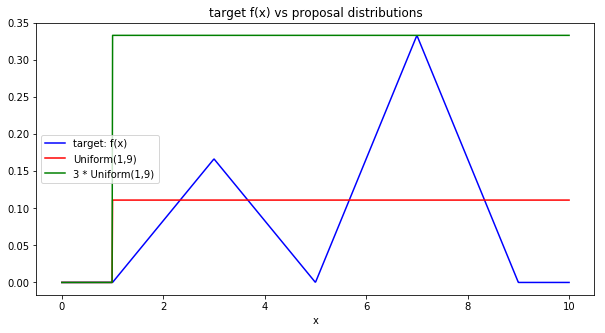

In [10]:
M = 3
uniform_pdf = sp.stats.uniform(1,9).pdf
plt.figure(figsize=(10,5))
x_linspace = np.linspace(0, 10, 1000)
plt.plot(x_linspace, list(map(f, x_linspace)), 'b-', label = 'target: f(x)')
plt.plot(x_linspace, uniform_pdf(x_linspace), 'r-', label = 'Uniform(1,9)')
plt.plot(x_linspace, M*uniform_pdf(x_linspace), 'g-', label = '{} * Uniform(1,9)'.format(M))
plt.xlabel('x')
plt.legend(loc='best')
plt.title("target f(x) vs proposal distributions")

As we can see from the plot above, a uniform distribution on (1,8) with a choice of $M=3$ covers $f(x)$ in its domain and thus it is a good candidate for a proposal distribution.

In [14]:
#function to draw samples using rejection sampling with a uniform proposal distribution
#arguments:
#target (function): target distribution function
#u1 (float):  left end of uniform distribution
#u2 (float): right end of uniform distribution
#M (float): the constant that we multiply the proposal with
#S (int): number of samples to return
def rejection_sampling_uniform(target, u1, u2, M, S):
    samples = []
    #we run the algorithm for S times
    for i in range(S):
        #get one sample from the uniform proposal
        proposed_sample = np.random.uniform(u1, u2, size=1)[0]
        #sample random height from U(0,1)
        u = np.random.uniform(0, 1)
        #accept proposed sample if u < f/Mg, else reject
        if u < target(proposed_sample)/(M*sp.stats.uniform(u1, u2).pdf(proposed_sample)):
            samples.append(proposed_sample)
    return np.array(samples)

In [15]:
#instantiate a rejection samples with proposal U(1,9) and M = 3 and set target to f
rejection_sampler_uni = partial(rejection_sampling_uniform, f, 1, 9, 3)
#total number of samples for one monte carlo estimate
S = 100
#total number of trials tha we repeat the experiment
trials = 500

rej_uni_estimates = monte_carlo(rejection_sampler, h, S, trials)

print('Mean of {} trials for naive monte carlo with {} samples using rejection sampling and uniform proposal: {}'.format(trials, S, np.mean(rej_uni_estimates)))
print('Variance of {} trials for naive monte carlo with {} samples using rejection sampling and uniform proposal: {}'.format(trials, S, np.std(rej_uni_estimates)**2))        
        

Mean of 500 trials for naive monte carlo with 100 samples using rejection sampling and uniform proposal: 2.4408185674713385
Variance of 500 trials for naive monte carlo with 100 samples using rejection sampling and uniform proposal: 0.10520326980929273


**3. Importance Sampling**

To implement Importance Sampling, we need to find a distribution $q(x)$ that is easy to sample from. Then, instead of calculating the naive Monte Carllo estimate of the expected value of $h(x)$, we will calculate the IS estimate as follows:

$$\mathbb{E}[h(X)] \approx\frac{1}{S}\sum_{s=1}^S \frac{f(X_s)}{q(X_s)}h(X_s), X_s \sim q(x)$$ 

First, we will implement Importance Sampling using a normal distribution for the importance distribution $q(x)$. However, choosing the exact distribution $q(x)$ that would result in minimal variance in our expectation estimate is not always an easy task. As a rule of thumb, we want $q$ to be proportional to $f$ so that importance weights are not too big or too small. However, we also know that the variance of the importance samping estimate is smaller when the importance distribution is proportional to the product of the nominal distibution and the function that we want to estimate the expectation for (i.e. $q\propto f(x)h(x)$). Hence, we will visualize the product of $f$ and $h$ to aid our understanding about the choice of g.

Text(0.5, 1.0, 'f(x)*h(x) vs normal pdfs')

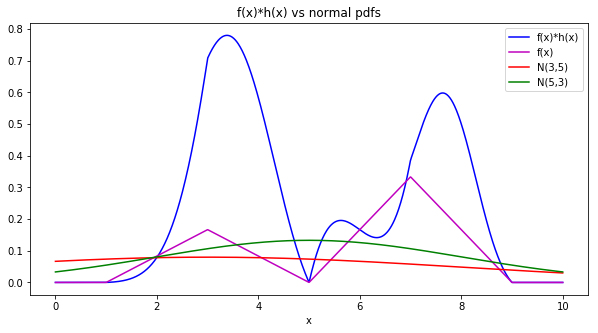

In [99]:
norm_3_5 = sp.stats.norm(loc=3, scale=5).pdf
norm_5_3 = sp.stats.norm(loc=5, scale=3).pdf
plt.figure(figsize=(10,5))
x_linspace = np.linspace(0, 10, 1000)
fh = []
for i in range(len(x_linspace)):
    fh.append(f(x_linspace[i])*h(x_linspace[i]))
plt.plot(x_linspace, fh, 'b-', label = 'f(x)*h(x)')
plt.plot(x_linspace, list(map(f, x_linspace)), 'm-', label = 'f(x)')
plt.plot(x_linspace, norm_3_5(x_linspace), 'r-', label = 'N(3,5)')
plt.plot(x_linspace, norm_5_3(x_linspace), 'g-', label = 'N(5,3)')
plt.xlabel('x')
plt.legend(loc='best')
plt.title("f(x)*h(x) vs normal pdfs")

We are implementing Importance Sampling using a wide normal $N(5,3)$ as our importance distribution, since this distribution is not 0 at points were $f(x)$ is 0 (if this was the case, we would get biased estimates).

In [34]:
#function to calculate expectation using importance sampling 
#with a normal importance distribution
#arguments:
#mean (float):  the mean of the normal importance distribution 
#var (float): the variance of the normal importance distribution
#nominal (function): the nominal distibution p
#expected_dist (function): the function of which the expectation we are estimating
#S (int): number of samples to when calculating one estimate
#trials (int): number of trials to repeat the experiment
def IS_normal(mean, var, nominal, expected_dist, S, trials):
    #array that holds the estimate for each trial
    IS_estimates = np.zeros(trials)
    #array that holds the weights for each trial and each sample
    weights = np.zeros((trials, S))
    for i in range(trials):
        #sample S samples from the Normal importance distribution
        q_samples = np.random.normal(mean, var, size=S)
        results = np.zeros(S)
        for j in range(S):
            #compute the importance weight for each sample and calculate f*h/q
            weights[i][j] = nominal(q_samples[j])/sp.stats.norm(loc=mean, scale=var).pdf(q_samples[j])
            results[j] = weights[i][j]*expected_dist(q_samples[j])
        estimate = np.mean(results)
        IS_estimates[i] = estimate
    #return both the estimates and the weights to calcualate ESS if needed
    return [IS_estimates, weights]

In [135]:
#number of samples to run IS
S = 100
#total number of trials tha we repeat the experiment
trials = 500
#teh aprameters of the importance normal distribution
mean = 5
var = 3
imp_normal_estimates = IS_normal(mean, var, f, h, S, trials)[0]

print('Mean of {} trials for IS with {} samples using N(5,3) for importance distribution: {}'.format(trials, S, np.mean(imp_normal_estimates)))
print('Variance of {} trials for IS with {} samples using N(5,3) for importance distribution: {}'.format(trials, S, np.std(imp_normal_estimates)**2))



Mean of 500 trials for IS with 100 samples using N(5,3) for importance distribution: 2.441123677318061
Variance of 500 trials for IS with 100 samples using N(5,3) for importance distribution: 0.05722928502420928


No we will implement importance sampling for a $Uniform(0,10)$ importance distribution as shown below.

In [19]:
#function to calculate expectation using importance sampling 
#with a uniform importance distribution
#arguments:
#u1 (float):  left end of uniform distribution
#u2 (float): right end of uniform distribution
#nominal (function): the nominal distibution p
#expected_dist (function): the function of which the expectation we are estimating
#S (int): number of samples to when calculating one estimate
#trials (int): number of trials to repeat the experiment
def IS_uniform(u1, u2, nominal, expected_dist, S, trials):
    #array that holds the estimate for each trial
    IS_estimates = np.zeros(trials)
    #array that holds the weights for each trial and each sample
    weights = np.zeros((trials, S))
    for i in range(trials):
        #sample S samples from the uniform importance distribution
        q_samples = np.random.uniform(u1, u2, size=S)
        results = np.zeros(S)
        for j in range(S):
            #compute the importance weight for each sample and calculate f*h/q
            weights[i][j] = nominal(q_samples[j])/sp.stats.uniform(u1, u2).pdf(q_samples[j])
            results[j] = weights[i][j]*expected_dist(q_samples[j])
        estimate = np.mean(results)
        IS_estimates[i] = estimate
    #return both the estimates and the weights to calcualate ESS if needed
    return [IS_estimates, weights]

In [27]:
#number of samples to run IS
S = 100
#total number of trials tha we repeat the experiment
trials = 500
#teh aprameters of the importance uniform distribution
u1 = 0
u2 = 10
imp_uni_estimates = IS_uniform(u1, u2, f, h, S, trials)[0]

print('Mean of {} trials for IS with {} samples using U(0,10) for importance distribution: {}'.format(trials, S, np.mean(imp_uni_estimates)))
print('Variance of {} trials for IS with {} samples using U(0,10) for importance distribution: {}'.format(trials, S, np.std(imp_uni_estimates)**2))

Mean of 500 trials for IS with 100 samples using U(0,10) for importance distribution: 2.443185390614443
Variance of 500 trials for IS with 100 samples using U(0,10) for importance distribution: 0.058995794183500844


**4. Stratified Sampling**

To calculate $\mathbb{E}[h(X_s)]$ using Stratified Sampling, we need to calculate the following Monte Carlo estimate over M different strata: 

$$
\mathbb{E}[h(X_s)] = \sum_{m=1}^M \frac{1}{S_m} \sum_{s_m=1}^{S_m} w_m h(X_{s_m}),\; X_{s_m} \sim \frac{f_m(X)}{w_m},
$$

where $f_m(X)$ is the definition of $f$ in the corresponding stratum.

In this case, we have defined 4 strata where the end points of the strata are given by $[1,3,5,6,9]$. Also to make $f(x)$ be a pdf over each stratum we need to normalize it. In other words the weight of each stratum is calculated as follows:


$$w_1 = \int_{1}^{3} f(x) dx = \frac{1}{6}$$
$$w_2 = \int_{3}^{5} f(x) dx = \frac{1}{6}$$
$$w_1 = \int_{5}^{7} f(x) dx = \frac{1}{3}$$
$$w_2 = \int_{7}^{9} f(x) dx = \frac{1}{3}$$

Hence, we need to sample from the following distributions:

$$f_1(x) = \frac{1}{2}(x-1)$$
$$f_2(x) = -\frac{1}{2}(x-5)$$
$$f_3(x) = \frac{1}{2}(x-5)$$
$$f_4(x) = -\frac{1}{2}(x-9)$$

To use inverse cdf sampling from each normalized piece $f_m$, we need to recompute the inverse CDF in each domain. Doing the calculations we obtain the inverse CDF for each $f_m$

$$F_1^{-1}(x) = 1 + 2\sqrt{x}$$
$$F_2^{-1}(x) = 5 - \sqrt{4(1-x)}$$
$$F_3^{-1}(x) = 5 + 2\sqrt{x}$$
$$F_4^{-1}(x) = 9 - \sqrt{4(1-x)}$$



In [44]:
#total sample size
S = 100 
strata = [1,3,5,7,9]
#list which holds the weights for each stratum
weights = [1.0/6.0, 1.0/6.0, 1.0/3.0, 1.0/3.0]
#define the inverse cdf for the normalized f in each stratum
F_1 = lambda x: 1 + 2*np.sqrt(x)
F_2 = lambda x: 5 - np.sqrt(4*(1-x))
F_3 = lambda x: 5 + 2*np.sqrt(x)
F_4 = lambda x: 9 - np.sqrt(4*(1-x))
functions = [F_1, F_2, F_3, F_4]
#list that holds the sample sizes for each stratum
Sm = [int(weight * S) for weight in weights]
trials = 500
#list that holds the stratified estimate for each trial
strat_estimates = []
#intialize list that holds the samples for each stratum
strata_samples = []
#repeat the experiment for number of trials
for i in range(trials):
    #compute the stratified sampling monte carlo estimate
    sum_over_strata = 0
    for m in range(len(strata) - 1):
        #sample from each function F using inverse cdf sampling
        Xm_samples = np.asarray(inverse_cdf_sampling(functions[m], Sm[m]))
        #append the samples for stratum m so that we can later visualize them
        strata_samples.append(Xm_samples)
        #compute the mc estimate for the mth stratum
        stratum_estimate = (weights[m] * h(Xm_samples)).mean()
        #add the mth estimate to the sum over strata
        sum_over_strata += stratum_estimate
    strat_estimates.append(sum_over_strata)
        
print('Mean of {} trials for Stratified Sampling with {} samples: {}'.format(trials, S, np.mean(strat_estimates)))
print('Variance of {} trials for Stratified Sampling with {} samples: {}'.format(trials, S, np.std(strat_estimates)**2))



Mean of 500 trials for Stratified Sampling with 100 samples: 2.4380022452728634
Variance of 500 trials for Stratified Sampling with 100 samples: 0.006127835498916702


## Part II. Debug Your Samplers

1. Visualize the pdf $f_X$ as well as samples obtained from Inverse CDF Sampling and Rejection Sampling (for both proposal distributions). It's probably better to make separate plots for each set of samples.

  What does the comparison say about the quality of your samples? In particular, which sampler (and which proposal distribution) produces "better" samples? Is this surprising -- i.e. use some properties of these samplers discussed in class to explain the patterns you're observing?
  
  **Hint:** you might find it helpful to visualize the proposal distributions along with $f_X$ in your analysis of rejection sampling.<br><br>

2. Visualize the distribution of the importance weights (one for each importance distribution). 
  
   Is the weight distribution surprising -- i.e. use some properties of these samplers discussed in class to explain the patterns you're observing?

   What do these importance weights tell you about the quality of your importance sampling estimate? 
   
     **Hint:** you might find it helpful to visualize the importnce distributions along with $f_X$ and $h$ in your analysis of importance sampling.<br><br>
     
3. Visualize the distribution of all the samples across strata. Is the distribution what you expect -- i.e. use some properties of these samplers discussed in class to explain the patterns you're observing?<br><br>

4. (**Extra Credit**) Compute the ***effective sample size (ESS)*** of the importance sampling estimates (for both distributions). You'll need to look up the definition of ESS (there are three commonly used definitions, pick any one). How does the effective sample size relate to the trends in the importance weight distributions?

**ANSWERS**

**1.** First we will visualize the pdf $f_X$ with samples obtained from Inverse CDF Sampling.

Text(0.5, 1.0, 'f(x) with a histogram of Inverse CDF samples')

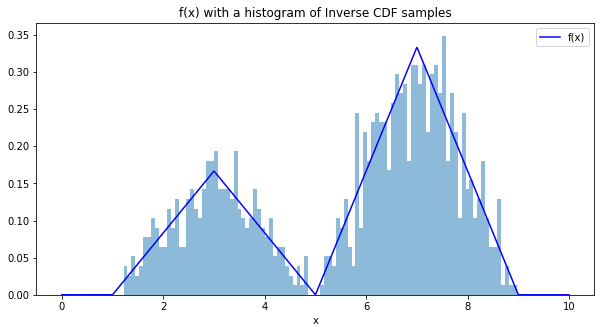

In [78]:
plt.figure(figsize=(10,5))
x_linspace = np.linspace(0, 10, 1000)
invcdf_samples = inverse_cdf_sampling(inv_cdf_f, 1000)
plt.plot(x_linspace, list(map(f, x_linspace)), 'b-', label = 'f(x)')
plt.hist(invcdf_samples, bins=100, alpha=0.5, density=True)
plt.xlabel('x')
plt.legend(loc='best')
plt.title("f(x) with a histogram of Inverse CDF samples")

Next we plotted the pdf $f_X$ with samples obtained from Rejection Sampling with normal $N(5,2)$ proposal and M=3.

Text(0.5, 1.0, 'f(x) with a histogram of Rejection samples from a normal proposal')

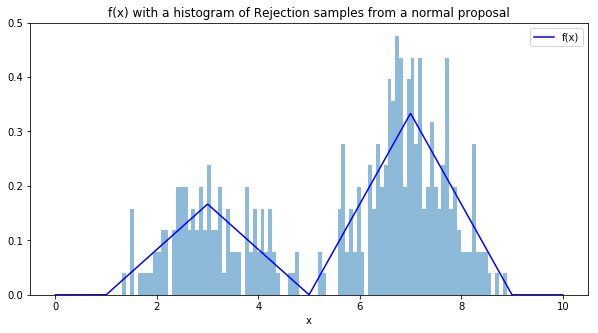

In [16]:
plt.figure(figsize=(10,5))
x_linspace = np.linspace(0, 10, 1000)
rejection_samples = rejection_sampling(f, 5, 2, 3, 1000)
plt.plot(x_linspace, list(map(f, x_linspace)), 'b-', label = 'f(x)')
plt.hist(rejection_samples, bins=100, alpha=0.5, density=True)
plt.xlabel('x')
plt.legend(loc='best')
plt.title("f(x) with a histogram of Rejection samples from a normal proposal")

Next we plotted the pdf $f_X$ with samples obtained from Rejection Sampling with $Uniform(1,9)$ proposal and M=3.

Text(0.5, 1.0, 'f(x) with a histogram of Rejection samples from a uniform proposal')

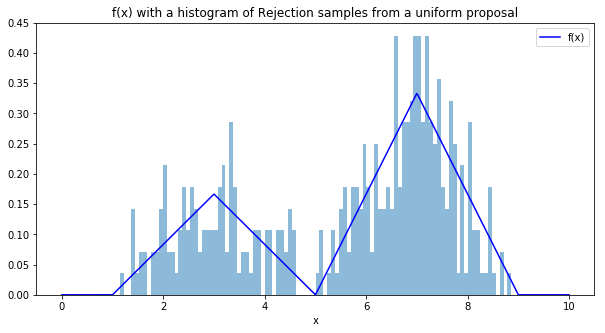

In [17]:
plt.figure(figsize=(10,5))
x_linspace = np.linspace(0, 10, 1000)
rejection_samples = rejection_sampling_uniform(f, 1, 9, 3, 1000)
plt.plot(x_linspace, list(map(f, x_linspace)), 'b-', label = 'f(x)')
plt.hist(rejection_samples, bins=100, alpha=0.5, density=True)
plt.xlabel('x')
plt.legend(loc='best')
plt.title("f(x) with a histogram of Rejection samples from a uniform proposal")

As it was asked in this exercise, we have implemented Rejection Sampling in a way that we run the algorithm for $S$ times and not until we accept $S$ samples from the target distribution. In both the cases of Normal and Uniform proposal distribution, the value of the constant $M$ that we chose was 3. As it is known, if we propose $S$ samples, the expected number of samples that a Rejection Sampler will accept is $\frac{S}{M}$. In this case, we generated the above visualizations for $S=1000$, hence on average the Rejection Sampler would only accept about 333 of them. 

On the contrary the Inverse CDF sampler produces 1000 samples for 1000 runs of the algorithm and thus it is able to provide a better quality of samples for the same number of runs. Hence, as it is also reflected in the graphs provided above, the samples from the Inverse CDF Sampler are more for the same number of runs and in turn they cover the shape of $f(x)$ much more tightly. 

However, both samplers come with a proof of correctness, that is the numbers sampled by both samplers have the distribution $f(x)$. Thus, samples generated by the rejection sampler also capture the general shape of the target distribution. Nevertheless, the number of samples kept effectively much lower than the samples produced by Inverse CDF Sampler. Hence, for the same number of runs, Rejection Sampling fails to sample as effectively from the whole distribution $f(x)$.

**2.** Below we created a histogram of the weights obtained from running importance sampling with normal importance distribution.

In [35]:
#number of samples to run IS
S = 100
#total number of trials tha we repeat the experiment
trials = 50
#teh aprameters of the importance normal distribution
mean = 5
var = 3
weights_norm = IS_normal(mean, var, f, h, S, trials)[1]

Text(0.5, 1.0, 'Histogram of importance weights for Normal importance')

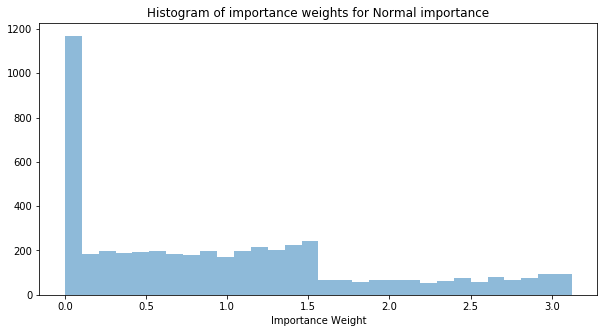

In [36]:
plt.figure(figsize=(10,5))
#weights is a matrix with dimensions trials x samples
#so we reshape to get a 1 dimensional array and plot a histogram
weights_norm = weights_norm.reshape((S*trials,))
plt.hist(weights_norm, bins=30, alpha=0.5)
plt.xlabel('Importance Weight')
plt.title("Histogram of importance weights for Normal importance") 

Below we created a histogram of the weights obtained from running importance sampling with uniform importance distribution.

In [37]:
#number of samples to run IS
S = 100
#total number of trials tha we repeat the experiment
trials = 50
#the aprameters of the importance uniform distribution
u1 = 0
u2 = 10
weights_uni = IS_uniform(u1, u2, f, h, S, trials)[1]

Text(0.5, 1.0, 'Histogram of importance weights for Uniform importance')

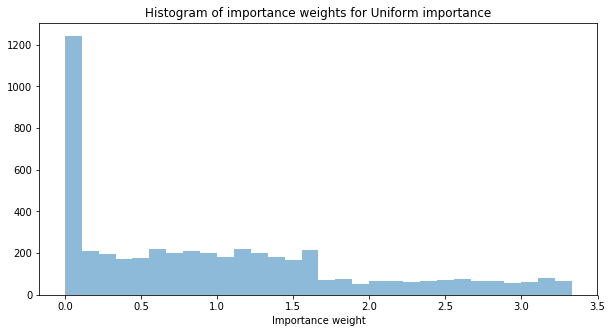

In [38]:
plt.figure(figsize=(10,5))
#weights is a matrix with dimensions trials x samples
#so we reshape to get a 1 dimensional array and plot a histogram
weights_uni = weights_uni.reshape((S*trials,))
plt.hist(weights_uni, bins=30, alpha=0.5)
plt.xlabel('Importance weight')
plt.title("Histogram of importance weights for Uniform importance") 

Text(0.5, 1.0, 'f(x) vs normal and uniform pdfs')

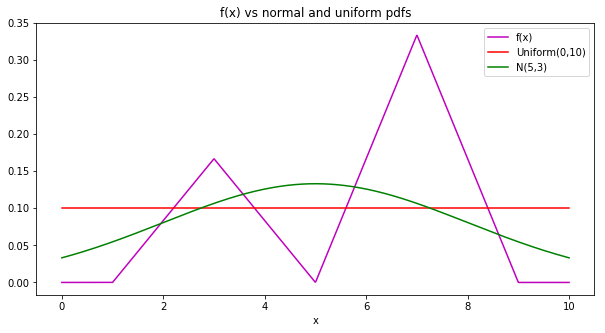

In [102]:
norm_5_3 = sp.stats.norm(loc=5, scale=3).pdf
uniform_pdf = sp.stats.uniform(0,10).pdf
plt.figure(figsize=(10,5))
x_linspace = np.linspace(0, 10, 1000)
plt.plot(x_linspace, list(map(f, x_linspace)), 'm-', label = 'f(x)')
plt.plot(x_linspace, uniform_pdf(x_linspace), 'r-', label = 'Uniform(0,10)')
plt.plot(x_linspace, norm_5_3(x_linspace), 'g-', label = 'N(5,3)')
plt.xlabel('x')
plt.legend(loc='best')
plt.title("f(x) vs normal and uniform pdfs")

As we can see from the two histograms and the above plot, the majority of weights are equal to 0 for both importance distributions. This is expected since the normal distribution that we picked is very wide and its center is at a point where $f(x)$ is 0. In other words, most of the samples from the normal $q(x)$ would be from around the center, where $f(x)$ is zero or very low. Hence, for most of the proposed samples, the weight $\frac{f(x)}{q(x)}$ will be zero or very low. Similarly, for samples out of the interval [1,9], $q(x)$ is non-zero but $f(x)$ is 0, leading to more zero weights. For proposed samples in the intervals [6,8] and [2.5,3.5], $q(x)$ will be low whereas $f(x)$ will be larger, leading to a few weights with a value between 1 and 3.

Similarly, the uniform pdf is non-zero for points where $f(x)$ is zero or very low (i.e. between 0 and 1.5, between 4.5 and 5.5 and between 9 and 10). Hence, for proposed samples from these areas, the weights will be very low close to 0.

Since the majority of weights are very low or 0 for both importance distributions, it is made obvious that the chosen $q(x)$ are not similar to $f(x)$. Hence, we would need significantly larger sample sizes to achieve any variance reduction using these distributions for $q(x)$.

**3.** 

Text(0.5, 1.0, 'f(x) with a histogram of stratified samples')

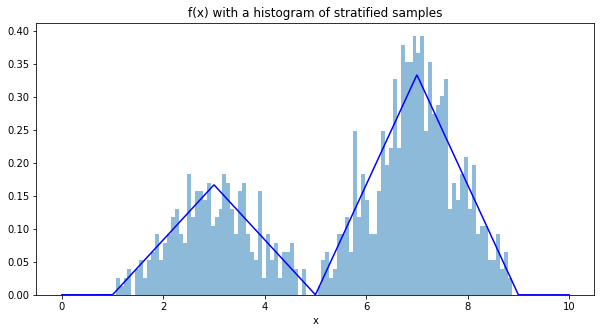

In [46]:
#total sample size
S = 100 
strata = [1,3,5,7,9]
#list which holds the weights for each stratum
weights = [1.0/6.0, 1.0/6.0, 1.0/3.0, 1.0/3.0]
#define the inverse cdf for the normalized f in each stratum
F_1 = lambda x: 1 + 2*np.sqrt(x)
F_2 = lambda x: 5 - np.sqrt(4*(1-x))
F_3 = lambda x: 5 + 2*np.sqrt(x)
F_4 = lambda x: 9 - np.sqrt(4*(1-x))
functions = [F_1, F_2, F_3, F_4]
#list that holds the sample sizes for each stratum
Sm = [int(weight * S) for weight in weights]
trials = 10
#list that holds the stratified estimate for each trial
strat_estimates = []
#intialize list that holds the samples for each stratum
strata_samples = []
#repeat the experiment for number of trials
for i in range(trials):
    #compute the stratified sampling monte carlo estimate
    sum_over_strata = 0
    for m in range(len(strata) - 1):
        #sample from each function F using inverse cdf sampling
        Xm_samples = np.asarray(inverse_cdf_sampling(functions[m], Sm[m]))
        #append the samples for stratum m so that we can later visualize them
        strata_samples.append(Xm_samples)
        #compute the mc estimate for the mth stratum
        stratum_estimate = (weights[m] * h(Xm_samples)).mean()
        #add the mth estimate to the sum over strata
        sum_over_strata += stratum_estimate
    strat_estimates.append(sum_over_strata)

#visualize 100 samples in total from 10 trials, hence 1000 samples in total
plt.figure(figsize=(10,5))
#unpack the samples of all strata in a single 1d numpy array
stratified_samples = strata_samples[0]
for i in range(1,len(strata_samples)):
    stratified_samples = np.append(stratified_samples, strata_samples[i])
x_linspace = np.linspace(0, 10, 1000)
plt.plot(x_linspace, list(map(f, x_linspace)), 'b-', label = 'f(x)')
plt.hist(stratified_samples, bins=100, alpha=0.5, density=True)
plt.xlabel('x')
plt.title("f(x) with a histogram of stratified samples")

In the above plot we have visualized 1000 samples from all the strata together. Since we have 1000 samples in total we have only used a proportion of this number to sample from each stratum. The general shape of the distribution is captured as expected, given that Stratified Sampling is theoretically guaranteed to give samples from the distribution that we seek to sample from. However, we can see that the effective number of samples per stratum is scaled down by the weight assigned to each stratum. For this reason, we would need more than 1000 samples in total to match the distribution perfectly in all of the strata.

**4.** A well-known ESS approximation is given by

$$ESS = \frac{1}{\sum_{s=1}^S \tilde{w_s^2}}$$

where $\tilde{w_s}$ refers to normalized weight $w_s$. Below, we are calcualting ESS both for the weights of importance sampling with normal importance distribution and the one with uniform distribution.

In [39]:
normalized_weights_norm = weights_norm/weights_norm.sum()
ESS_norm = 1.0/(normalized_weights_norm**2).sum()

normalized_weights_uni = weights_uni/weights_uni.sum()
ESS_uni = 1.0/(normalized_weights_uni**2).sum()

print("ESS for normal importance distribution is {}".format(ESS_norm))
print("ESS for uniform importance distribution is {}".format(ESS_uni))

ESS for normal importance distribution is 2746.5715725980085
ESS for uniform importance distribution is 2669.5400133471408


In both cases, we calculated the ESS for an original sample of 5000 weights (i.e. 500 trials times 100 samples each). As we can see, the effective sample size for both distributions is almost half of the original sample size. This was expected after looking at the corresponding weight distributions since the majority of weights are very low close to 0.

## Part III: Variance Reduction

1. Compute the sample variance of the four Monte Carlo estimates in Part I. Based on the discussions in lecture, which sampling methods (and proposal/importance distributions) is expected, in principle, to resulted in lower variances? How well do your results align with these expectations?<br><br>

3. Based on your experiments, would you feel comfortable concluding which type of Monte Carlo estimate will **generally** have the lowest variance? Why or why not?<br><br>

4. (**Extra Credit**) Implement the control variate Monte Carlo estimate for $I$ for your choice of a control variate $g$ and sample using the inverse CDF sampler. Argue for why your choice of $g$ is appropriate and demonstrate that your control variate estimate has lower variance than the naive Monte Carlo using inverse CDF sampling.

**ANSWERS**

**1.** In Part 1, the mean and variance of each Monte Carlo estimate was calculated for a sample size of 100 and 500 trials. Below, we summarize the results:

a. Naive Monte Carlo with Inverse CDF Sampling:
$$Mean = 2.432, Var = 0.033$$
b. Naive Monte Carlo with Rejection Sampling with normal proposal distribution $N(5,2)$ and $M=3$:
$$Mean = 2.450, Var = 0.106$$
c. Naive Monte Carlo with Rejection Sampling with uniform proposal distribution $Uniform(1,9)$ and $M=3$:
$$Mean = 2.441, Var = 0.105$$
d. Importance sampling with $N(5,3)$ for importance distribution:
$$Mean = 2.441, Var = 0.057$$
e. Importance sampling with $Uniform(1,9)$ for importance distribution:
$$Mean = 2.443, Var = 0.059$$
f. Stratified sampling:
$$Mean = 2.436, Var = 0.006$$

In principle, it is expected that Importance Sampling and Stratified Sampling should result in lower variances than the other methods checked. However, in practice, Importance Sampling using the distributions discussed above, results in even higher variance than the naive Monte Carlo algorithm. This is beacause the importance distributions that we used did not look like the bimodal nominal distribution $f(x)$, hence the majority of weights were very low. 

On the contrary, Stratified Sampling performed according to our expectations resulting in variance which is almost 10 times lower than the one of the naive Monte Carlo method.


**2.** Based on our experiments, we can see that out of the methods checked, Stratified Sampling results in the lowest variance since we were able to partition $f(x)$ in smoother strata, in the domain of which the function has little variation. However, we would not feel comfortable concluding that this estimate will generally have the lowest variance, since we did not experiment with Importance Sampling enough. If we experimented more, maybe we could find a distribution $q(x)$ which is more similar to the bimodal structure of $f(x)$ and in turn we would manage to produce estimates with even lower variance.

In other words, there is no theoretical guarantee that a given algorithm would achieve the minimal variance estimate for a given function. It all depends on the choices that we make when constructing these variance reduction algorithms.

**3.** Essentially, our control variate $g(x)$ needs to have a high correlation with the function $h(x)$. By plotting $h(x)$, we can see that a candidate control variate would be a 6th order polynomial with double roots placed on the tails of each of the two modes of the function $h(x)$. By visual inspection, we can see that if we put the roots around 1.5, 6.5 and 9.3, we are getting a function with very similar shape to that of $h(x)$ in the domain of $f(x)$ (i.e. [1,9]). By dividing with 200, we can reduce the scale of $g(x)$ to values comparable to the ones taken by $h(x)$.

(0, 20)

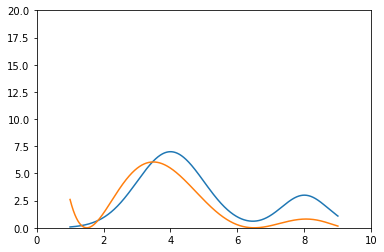

In [486]:
g = lambda x: (x-1.5)**2 * (x-6.5)**2 * (x-9.3)**2/200
x_linspace = np.linspace(1,9,10000)
plt.plot(x_linspace, h(x_linspace))
plt.plot(x_linspace, g(x_linspace))
plt.xlim(0,10)
plt.ylim(0,20)

To implement the control variate, we need to find the mean of $g(x)$ with respect to the function that we draw samples from (i.e. $f(x)$). Below, we are doing that my performing numerical integration on the domain of $f(x)$.

In [487]:
from scipy.integrate import quad
mean_g = quad(lambda x: g(x)*f(x), 1, 9)[0]
mean_g

1.7040450297619052

Next, we need to make a choice about the parameter $c$. According to theory, the optimal value for this parameter is given by the ratio $\frac{cov[(g(x), h(x)]}{\sigma_g^2}$. Below, we are calculating the numerator and denominator empirically from 10000 samples of x in the interval [1,9].

In [488]:
np.cov(g(x_linspace), h(x_linspace))

array([[4.40850417, 3.78176173],
       [3.78176173, 4.42885715]])

In [492]:
cov = np.cov(g(x_linspace), h(x_linspace))[0,1]
g_var = np.cov(g(x_linspace), h(x_linspace))[0,0]
c = cov/g_var

control_mc = lambda x: h(x) - c*(g(x) - mean_g)
S = 100
#total number of trials tha we repeat the experiment
trials = 500

control_mc_estimates = monte_carlo(inv_cdf_sampler, control_mc, S, trials)

In [493]:
np.mean(control_mc_estimates)

2.436020699859191

In [494]:
np.std(control_mc_estimates)**2

0.008270732456823771

From the results shown above, we can see that we are getting unbiased estimates of the expectation of $h(x)$. At the same time, the variance of the estimate (0.0083) is reduced by almost 4 times compared to the naive monte carlo approach, for the same number of trials and samples.